# Hazard assessment: historical climate

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FIRE](https://github.com/CLIMAAX/FIRE) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

In this notebook, we extract data for a location of interest from the Fire Weather Index (FWI) dataset of [El Garroussi et al. (2024)](https://doi.org/10.1038/s41612-024-00575-8) and explore the historical timeseries contained in the dataset.

## Preparation work

### Load libraries

:::{admonition} Information about the libraries used in this workflow
:class: hint dropdown

- [pathlib](https://docs.python.org/3/library/pathlib.html) - Convenient file path representation and manipulation.
- [numpy](https://numpy.org/) - A powerful library for numerical computations, widely used for array operations and mathematical functions.
- [pandas](https://pandas.pydata.org/) - A data manipulation and analysis library, essential for working with structured data in tabular form.
- [geopandas](https://geopandas.org/en/stable/index.html) - Geometric operations for geospatial data in pandas.
- [xarray](https://docs.xarray.dev/en/stable/) - Library for working with labelled multi-dimensional arrays.
- [earthkit.meteo](https://earthkit-plots.readthedocs.io/en/latest/) - Meteorological computations and statistical analysis.
- [earthkit.plots](https://earthkit-plots.readthedocs.io/en/latest/) - Visualisation tools and templates designed for earth science data.
- [gisco_geodata](https://github.com/alecsandrei/gisco-geodata) - Access to the European Commission's GISCO geospatial data.

Most of these libraries depend on other libraries in the background, e.g., [scipy.stats](https://docs.scipy.org/doc/scipy/reference/stats.html) for statistical data processing, [matplotlib](https://matplotlib.org) for plotting via earthkit.plots or [dask](https://www.dask.org/) and [zarr](https://zarr.readthedocs.io/) to read data with xarray.
:::

In [1]:
import pathlib

import earthkit.meteo.stats as ekm_stats
import earthkit.plots as ekp
import geopandas as gpd
import gisco_geodata
import numpy as np
import pandas as pd
import xarray as xr

### Path configuration

In [2]:
data_dir = pathlib.Path("./data")

## Step 1: Load FWI dataset

We use the perturbed historical Fire Weather Index simulations of [El Garroussi (2024)](https://doi.org/10.5281/zenodo.10458186) to construct our FWI response model.
The original dataset is a collection of GRIB files where each file contains one perturbed simulation and each GRIB message inside the files represents a horizontal slice for an output timestep.


### Option 1A: zarr dataset from CLIMAAX cloud storage (recommended)

For the purposes of this workflow, the layout of the dataset as available on Zenodo is inconvenient, as we are interested in accessing all simulations and all timesteps but only for a specific location and not the full horizontal slice.
CLIMAAX provides a [mirror of the original dataset](https://handbook.climaax.eu/resources/datasets/fwi_1981-2010_europe.html) in a zarr format and with reordered and chunked dimensions specifically to make the local-in-space access pattern in this workflow efficient.
This avoids the need to download the full dataset (~50 GB) only to subsequently discard most of the data in an analysis for a limited spatial domain.
We load the access-optimized dataset here:

In [3]:
fwi = xr.open_zarr("https://object-store.os-api.cci1.ecmwf.int/climaax/fwi_1981-2010_europe/", chunks={})

### Option 1B: original dataset from Zenodo

If you have the original dataset from Zenodo and do not wish to use the CLIMAAX-provided cloud dataset, you can use the following cell to load the GRIB files with xarray into a compatible dataset instead: (uncomment the code first)

In [4]:
#def add_delta_coords(ds):
#    """Add dp and dt coordinates based on values in filenames"""
#    path = ds.encoding["source"]
#    assert path[-27] == "T" and path[-22] == "P"
#    return ds.assign_coords({
#        "dt": [float(path[-26:-23])],
#        "dp": [float(path[-21:-18])]
#    })

## Needs earthkit or cfgrib engine to read GRIB files with xarray
#fwi = xr.open_mfdataset(
#    "data/FWI_EU_1981-2010/FWI_T*_P*_EU_1981_2010.grib",
#    engine="earthkit",
#    preprocess=add_delta_coords,
#    chunks={}
#)
#fwi = fwi.dropna("values", how="any")

:::{warning}

The option to run the workflow based on the original Zenodo data is provided here for completeness.
You will experience significantly higher memory consumption and computing times when using this dataset compared to the zarr dataset in Option A.
:::

### Adding convenience

Preselect the `fwinx` variable (fire weather index) for all future access:

In [5]:
fwi = fwi["fwinx"]

Shift the longitude coordinate into the range (-180, 180) from (0, 360) to avoid a discontinuity at the prime meridian in the middle of Europe:

In [6]:
fwi["longitude"] = (fwi["longitude"] + 180) % 360 - 180

Convert the precipitation change coordinate to relative percentages:

In [7]:
fwi = fwi.assign_coords({"dp": 100 * (fwi.coords["dp"] - 1)})

### Dataset information

In [8]:
fwi

<xarray.DataArray 'fwinx' (values: 12235, dp: 6, dt: 6, time: 10957)> Size: 39GB
dask.array<open_dataset-fwinx, shape=(12235, 6, 6, 10957), dtype=float64, chunksize=(32, 6, 6, 10957), chunktype=numpy.ndarray>
Coordinates:
  * dt          (dt) float64 48B 0.0 1.0 2.0 3.0 4.0 5.0
    latitude    (values) float64 98kB dask.array<chunksize=(12235,), meta=np.ndarray>
    longitude   (values) float64 98kB dask.array<chunksize=(12235,), meta=np.ndarray>
    step        timedelta64[ns] 8B ...
    surface     float64 8B ...
  * time        (time) datetime64[ns] 88kB 1981-01-01 1981-01-02 ... 2010-12-31
    valid_time  (time) datetime64[ns] 88kB dask.array<chunksize=(10957,), meta=np.ndarray>
  * dp          (dp) float64 48B -40.0 -20.0 0.0 20.0 40.0 60.0
Dimensions without coordinates: values
Attributes: (12/20)
    GRIB_N:                          320
    GRIB_NV:                         0
    GRIB_cfName:                     unknown
    GRIB_cfVarName:                  fwinx
    GRIB_dataType:                   fc
    GRIB_gridDefinitionDescription:  Gaussian latitude/longitude
    ...                              ...
    GRIB_stepUnits:                  1
    GRIB_typeOfLevel:                surface
    GRIB_units:                      Numeric
    long_name:                       Forest fire weather index (as defined by...
    standard_name:                   unknown
    units:                           Numeric

:::{note}

The precipitation and temperature perturbations in the simulations are quantified by the `dp` and `dt` coordinates:

- `dp`: precipitation, relative change (`-20` = 20% less, `0` = no change, `20` = 20% more, etc.)
- `dt`: temperature, absolute change (`0.0` = no warming, `1.0` = warming by 1°C, etc.)

Each parameter is specified relative to the actual historical climate as represented in ERA5 (unperturbed simulation with `dp=0.0`, `dt=0.0`).
:::

We extract some basic information from the dataset for later use:

In [9]:
data_year_start = fwi.coords["time"].dt.year.min().values
data_year_end = fwi.coords["time"].dt.year.max().values

grid_lat = fwi.coords["latitude"].values
grid_lon = fwi.coords["longitude"].values

## Step 2: Extract and aggregate regional data

We extract data for a region of interest.
The goal in this step is to obtain a single timeseries per simulation experiment for further processing by reducing the data along the latitude and longitude dimensions.

Here, we compute the average conditions of all grid points of a [NUTS](https://ec.europa.eu/eurostat/web/nuts/) region.

:::{note}

A reduction of the dimensionality of the dataset arises as a requirement of the data presentation/visualization.
The input dataset has 5 dimensions (latitude, longitude, time and two for the perturbations) and the method of analysis employed in the hazard assessment workflow introduces additional parameters (FWI threshold, climate projection scenario).
A reduction to a dimensionality suitable for visualization therefore requires a reduction.

Here, we start the analysis with an aggregation in space, but other schemes can can be implemented on top of the full-dimensional dataset loaded in Step 1.
:::

Specify a NUTS region and retrieve the required geographical information for selecting grid points:

In [10]:
nuts = gisco_geodata.NUTS()
region = nuts.get(
    countries="ES61",  # put a NUTS ID here
    nuts_level="LEVL_2",  # adjust the NUTS level to match your ID
    scale="10M",  # select data resolution (1M, 3M, 10M, 20M or 60M)
    spatial_type="RG",
    projection="4326"
)

# Extract a label from the NUTS data (override with a custom name if desired)
location = "+".join(region["NUTS_ID"])

print(f"Selected NUTS domain: {location}")

Selected NUTS domain: ES61


:::{tip}

To customize the workflow,

- put the ID of a NUTS region of your choice for the `countries` argument and make sure the `nuts_level` argument is adjusted appropriately or
- load a shapefile of your choice into the variable `region` instead and assign a label to the variable `location`.
:::

Select all grid points inside the chosen NUTS domain:

In [11]:
grid_points = gpd.GeoDataFrame().set_geometry(
    gpd.points_from_xy(fwi.coords["longitude"], fwi.coords["latitude"], crs="EPSG:4326")
)
nuts_grid_points = gpd.sjoin(grid_points, region, how="inner")

nuts_grid_lon = nuts_grid_points.geometry.x
nuts_grid_lat = nuts_grid_points.geometry.y

Visualize all selected grid points:

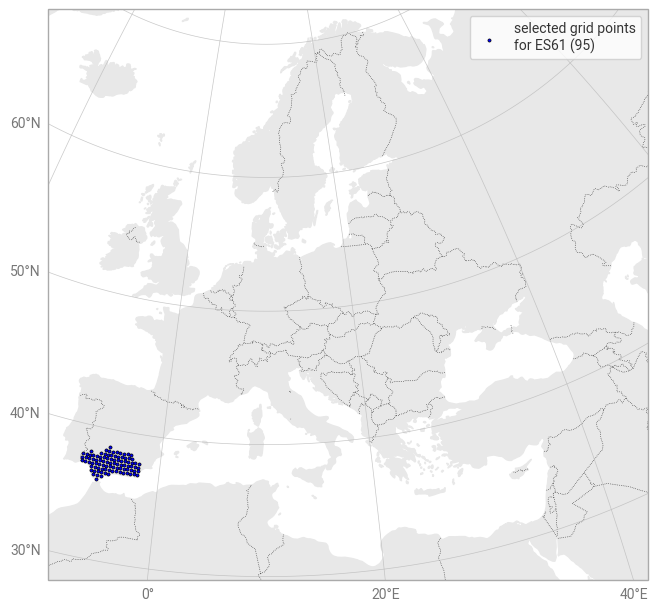

In [12]:
subplot = ekp.Map(domain="Europe")

a = subplot.scatter(x=nuts_grid_lon, y=nuts_grid_lat, c="blue", s=5)
subplot.ax.legend([a], [f"selected grid points\nfor {location} ({len(nuts_grid_points)})"])

subplot.land()
subplot.borders()
subplot.gridlines()

To reduce the dataset, take the mean over all selected grid points:

In [13]:
nuts_lon_mask = np.isin(grid_lon, nuts_grid_lon)
nuts_lat_mask = np.isin(grid_lat, nuts_grid_lat)

location_fwi = fwi[nuts_lon_mask & nuts_lat_mask].mean(dim="values").load()

:::{important}

The method of aggregation chosen here has significant impact on the interpretation of the results of following analysis.
The mean taken by default generally dampens the magnitude of the largest extrema of the dataset, resulting in a more conservative estimate of fire danger for the region.
Other options to consider are taking the maximum as a highest-hazard scenario or the minimum as a lowest-hazard scenario for the region.
:::

## Step 3: Select simulation

The FWI timeseries data from the historical model simulations is now ready for processing.
Take data from the unperturbed simulation to explore the properties of the historical reference climate:

In [14]:
fwi_series = location_fwi.sel({"dp": 0.0, "dt": 0.0}).to_series()

:::{tip}

You can replace the values of `dp` and `dt` in the cell above to consider data from a perturbed scenario in the plots of the next section.
:::

## Step 4: Analysis

### Yearly variation of FWI

Visualize the yearly evolution of FWI for the 30-year timeseries in terms of the minimum, median, maximum and intermediate 25 and 75 percentiles on each day of the year.

In [15]:
fwi_series_years = fwi_series.set_axis(
    pd.MultiIndex.from_arrays([
        fwi_series.index.year,
        fwi_series.index.dayofyear
    ], names=["year", "dayofyear"])
).to_xarray()

Text(0.5, 0, 'FWI')

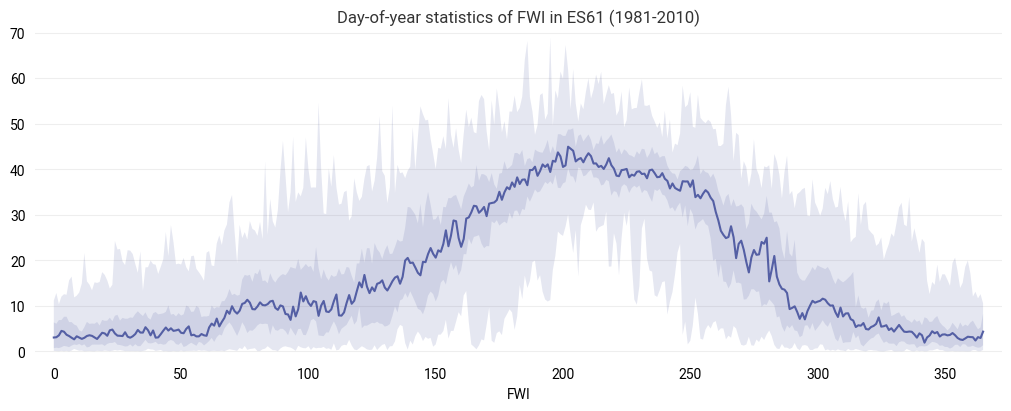

In [16]:
figure = ekp.Figure(size=(10, 4))

subplot = figure.add_subplot()
subplot.title(f"Day-of-year statistics of FWI in {location} ({data_year_start}-{data_year_end})")

subplot.quantiles(fwi_series_years, dim="year", quantiles=[0.0, 0.25, 0.5, 0.75, 1.0], alpha=0.15)

subplot.ax.set_xlabel("day of year")
subplot.ax.set_xlabel("FWI")

### Return period estimation

Estimate the return period of the maximum FWI in a given year based on the historical timeseries:

In [17]:
def ranked_table(fwi_series):
    # Yearly maximum FWI
    fwi_max = fwi_series.groupby(fwi_series.index.year).max()
    # Prepare DataFrame for analysis
    df = fwi_max.to_frame(name="FWI")
    df["rank"] = df.rank(method="min", ascending=False)
    # Probability of exceedance (in %) with Weibull formula
    df["PE"] = (df["rank"] / (len(df) + 1)) * 100
    # Convert probability to return period (in years)
    df["RP"] = 100. / df["PE"]
    # Sort the DataFrame based on rank (i.e. FWI values)
    return df.reset_index().set_index("rank").sort_index()

In [18]:
fwi_ranked = ranked_table(fwi_series)

# Display table of ranked years
fwi_ranked.round(1)

,time,FWI,PE,RP
rank,,,,
1.0,1994,69.0,3.2,31.0
2.0,2009,67.3,6.5,15.5
3.0,1995,62.0,9.7,10.3
4.0,2000,61.5,12.9,7.8
5.0,2003,60.8,16.1,6.2
6.0,1981,60.0,19.4,5.2
7.0,1998,58.5,22.6,4.4
8.0,2005,58.4,25.8,3.9
9.0,1983,58.1,29.0,3.4


For example, an entry of

- **rank**: 10.0
- **year**: 2001
- **FWI**: 57.7
- **PE**: 32.3
- **RP**: 3.1

in the table would mean that the highest value of the FWI seen in the year 2001 at the selected location was approximately 57.7, making it the 10th highest-ranking year of the full timeseries.
The **probability of exceedance (PE)** for experiencing a FWI larger or equal to 57.7 in any given year is estimated around 32.3% based on the data with a corresponding **return period (RP)** of 3.1 years.

:::{note}

The length of the timeseries restricts the length of the maximum return period unless further assumptions are made.
:::

### Continuous model for probability of exceedance

We "fill the gaps" in the table above by fitting a Gumbel distribution as a statistical model for extreme values to the yearly FWI maxima.
This results in a continuous curve for the probability of exceedance.

In [19]:
# Fit the statistical model
fwi_dist = ekm_stats.GumbelDistribution.fit(fwi_ranked["FWI"])

# Evaluate the fitted distribution for plotting
fwi_samples = pd.DataFrame({
    "FWI": np.linspace(min(fwi_ranked["FWI"])-5, max(fwi_ranked["FWI"])+5, 100)
})
fwi_samples["PE"] = 100. * fwi_dist.cdf(fwi_samples["FWI"])
fwi_samples["RP"] = ekm_stats.value_to_return_period(fwi_dist, fwi_samples["FWI"])

Check the quality of the fit by plotting the probability of exceedance based on the fitted distribution model together with the estimated probability of exceedance from the ranked table above:

Text(0, 0.5, 'probability of exceedance (%)')

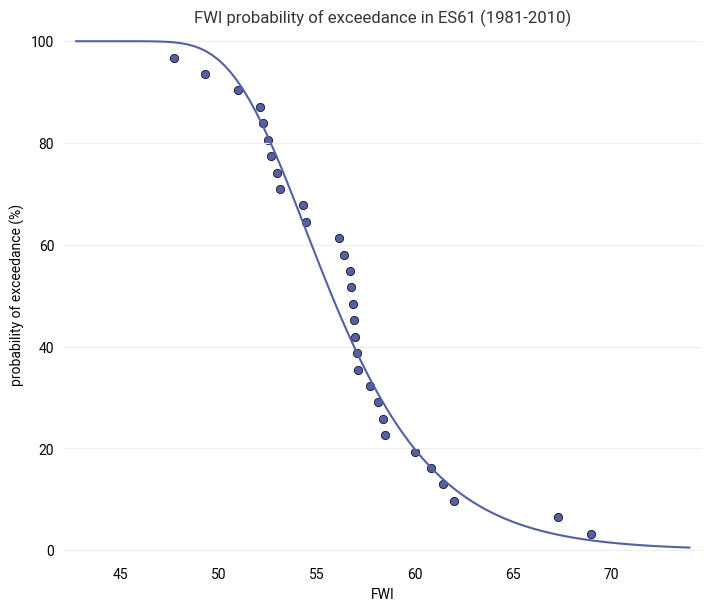

In [20]:
subplot = ekp.Subplot()
subplot.title(f"FWI probability of exceedance in {location} ({data_year_start}-{data_year_end})")

subplot.line(x=fwi_samples["FWI"], y=fwi_samples["PE"])
subplot.scatter(x=fwi_ranked["FWI"], y=fwi_ranked["PE"])

subplot.ax.set_xlabel("FWI")
subplot.ax.set_ylabel("probability of exceedance (%)")

The fittted distribution should follow the data closely (though not necessarily exactly).
It allows us to fill the gaps between the samples from the table and to extrapolate to return periods longer than the 30 year span of the dataset.

### Duration of the average fire season

Define the length of the average fire season as the number of days where the FWI exceeds half the value of the 20-year return period, following [El Garroussi et al. (2024)](https://doi.org/10.1038/s41612-024-00575-8).

First, determine the FWI of the 20-year return period based on the maximum values distribution:

In [21]:
fwi_20yr = ekm_stats.return_period_to_value(fwi_dist, 20.)

print(f"FWI of the 20-year return period in {location}: {fwi_20yr:.1f}")

FWI of the 20-year return period in ES61: 65.4


:::{note}

The 20-year return period corresponds to a 5% probability of exceedance.
:::

Then, count the number of days in each year where the FWI exceeded half the value of the 20-year return period:

In [22]:
def yearly_fire_season_length(fwi_series, threshold):
    return (fwi_series > threshold).groupby(fwi_series.index.year).sum()

In [23]:
fire_season_length = yearly_fire_season_length(fwi_series, threshold=(0.5 * fwi_20yr))

Text(0.5, 1.0, 'Number of days in fire season in ES61')

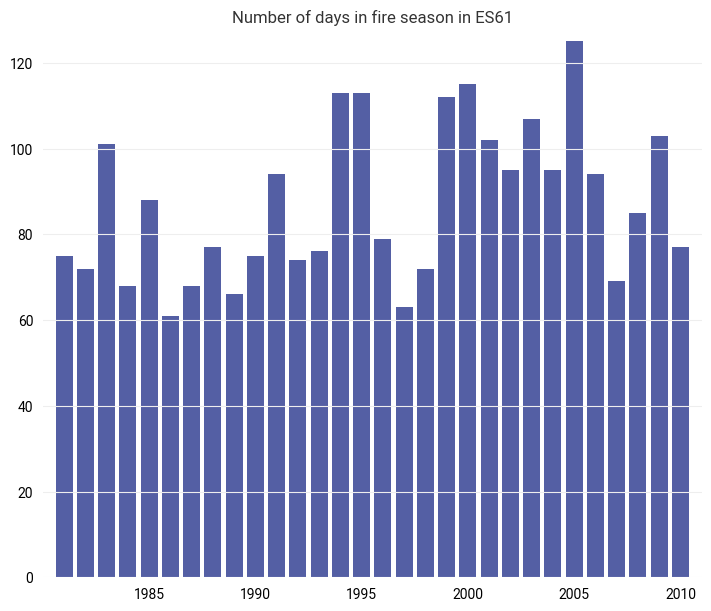

In [24]:
subplot = ekp.Subplot()
subplot.bar(x=fire_season_length.index, y=fire_season_length)
subplot.title(f"Number of days in fire season in {location}")

The average over all years yields the average fire season length for the selected location:

In [25]:
print(f"{data_year_start}-{data_year_end} average fire season length in {location}: {fire_season_length.mean():.1f} days")

1981-2010 average fire season length in ES61: 87.1 days


:::{note}

This definition of the average fire season length is *relative*, as it depends on the value of the FWI for the location-specific 20-year return period.
:::

## Step 5: Export data

Create an output folder for the selected region:

In [26]:
out_dir = data_dir / location
out_dir.mkdir(parents=True, exist_ok=True)

Export the extracted FWI timeseries for all scenarios:

In [27]:
out = location_fwi.to_dataset()
out.attrs["location"] = location
out.to_netcdf(out_dir / "fwi_timeseries.nc")

print(f"Data written to '{out_dir}'")

Data written to 'data/ES61'


Save the region geometry for use in next steps of the workflow:

In [28]:
region.to_file(out_dir / "region")

## Summary

In this first part of the hazard assessment of the workflow, a regional dataset of Fire Weather Index was extracted from the simulations of [El Garroussi et al. (2024)](https://doi.org/10.1038/s41612-024-00575-8).
Important statistical concepts for the following analysis were introduced with an initial look at the historical timeseries of FWI from the unperturbed simulation.

In the next part of the hazard assessment ([response surface methodology](hazard_assessment_response.ipynb)), the regional dataset saved here is picked up and processed to yield a response surface model of FWI in dependence of temperature and precipitation.